**Assignment 2**
----------------------------------
**Name** : *Ahmad Farhan* <br>
**Roll No.** : *i211366* <br>
**Section** : *C* <br>
__________________________________

1. [Data Preprocessing](#Data-Preprocessing)
2. [Model Implementation](#Model-Implementation)
3. [Model Evaluation](#Model-Evaluation)
4. [Cross-Validation](#Cross-Validation)
5. [Error Analysis](#Error-Analysis)
6. [Conclusion](#Conclusion)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

## Data Preprocessing

In [2]:
import math
import time
from nltk.corpus import stopwords
# nltk.download('stopwords')

# Convert all text to Lowercase
def lowercase(corpus):
    for i in range(len(corpus)):
        corpus[i] = corpus[i].lower()
    return corpus

# Remove Punctuation from the corpus
punctuation = '''.!"#$%&()*+,-./:;<=>?@[\\]^_{|}~`'''
def removepunct(corpus):
    for i in range(len(corpus)):
        for p in punctuation:
            corpus[i] = corpus[i].replace(p, ' ')
    return corpus

# Remove stopwords from sequences
def clearstopwords(sequences):
    filtered = []
    stopwords_ = stopwords.words('english')
    for sequence in sequences:
        seq = [word for word in sequence if word not in stopwords_]
        filtered.append(" ".join(seq))
    return filtered

# Split sequences into individual words (tokenization)
def removespaces(corpus): 
    return [sequence.split() for sequence in corpus]
# Flatten a list of lists into a single list of words
def flatten(corpus): 
    return [word for sublist in corpus for word in sublist.split()]
# Combine word sequences into sentences
def combine(corpus):
    return [" ".join(seq) for seq in corpus]

# Main preprocessing pipeline
def preprocess(corpus):
    corpus = lowercase(corpus)
    print("Lowercased...")
    corpus = removepunct(corpus)
    print("Punctuations Removed...")
    corpus = removespaces(corpus)
    print("Extra Spaces Removed...")
    corpus = clearstopwords(corpus)
    print("Stopwords Removed...")
    return corpus

In [3]:
file_data = pd.read_csv('dataset\XSum_Hallucination.csv')
file_data = file_data[['summary', 'is_factual']]
file_data = file_data.dropna()

factual = file_data['is_factual'].values
corpus = file_data['summary'].values
corpus = preprocess(corpus)
file_data['summary'] = corpus
file_data.head()

Lowercased...
Punctuations Removed...
Extra Spaces Removed...
Stopwords Removed...


,summary,is_factual
0,50 pupils bristol academy sent home school lac...,no
1,50 pupils bristol academy sent home school lac...,no
2,50 pupils bristol academy sent home school lac...,no
3,wife british iranian woman jailed iran called ...,no
4,wife british iranian woman jailed iran called ...,no


In [15]:
# Function to count the occurrences of each n-gram in the corpus
def get_vocab(words):
    unique_words = set(words) # Get unique n-grams
    vocab = {x:i for i,x in enumerate(unique_words)}
    return vocab

# Function to seperate the data into labels (positive/negative) with their sequences
def classify_data(file_data):
    class_sequences = {}
    for seq, label in file_data:  # Iterate through each sequence and its label
        if label not in class_sequences:
            class_sequences[label] = [] # Initialize list for each label
        class_sequences[label].append(seq)  # Add sequence to its label category
    return class_sequences

# Calculate total words in the corpus
classes = file_data['is_factual'].unique()
total_words = sum(len(x.split()) for x in corpus)
# Create vocabulary from Corpus
vocab = get_vocab(flatten(corpus))
# Classify sequences into respective labels
cls_seqs = classify_data(file_data.values.tolist())
print("Dataset Statistics")
print("----------------------------")
print("Total Sequences:", len(corpus))
print("Vocabulary Size:", len(vocab))
print("Total Words:", total_words)
print("Classes:", classes)
print("\nClassified as")
print("----------------------------")
for key, values in cls_seqs.items():
    print(f"{key}: {len(values)}")

Dataset Statistics
----------------------------
Total Sequences: 5564
Vocabulary Size: 4324
Total Words: 61489
Classes: ['no' 'yes']

Classified as
----------------------------
no: 4982
yes: 582


In [71]:
# Encode class labels as integers for easier processing
def labelEncoder(y_values, classes):
    encoded = []; encoder = {}
    for i, cls in enumerate(classes):
        encoder[cls] = i
    for y_value in y_values:
        encoded.append(encoder[y_value])
    return np.array(encoded)

# Mean Normalization of Input Data
def normalizeInput(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    std[std == 0] = 1
    return (data - mean) / std

# Convert Corpus to Bag of Words Counts
def countVectorizer(corpus, vocab):
    X = np.zeros((len(corpus),len(vocab)), dtype=int)
    for doc_index, doc in enumerate(corpus):
        words = doc.split()             # Split document into words
        for word in words:
            col_index = vocab[word]
            X[doc_index, col_index] += 1
    return X

# Display data distribution by class
def show_data_distribution(data, cls):
    dataset = [(data[i], cls[i]) for i in range(cls.shape[0])]
    dataset = classify_data(dataset)
    for key, values in dataset.items():
        print(f"{key}: {len(values)}")

# Function to split classified data into train and test sets
def train_test_split(X, y, seqs, test_size=0.2, random_state=None):
    if random_state is not None: np.random.seed(random_state)
    indices = np.random.permutation(len(X))  # Shuffle indices
    split_index = int(len(X) * (1 - test_size))  # Determine split point

    # Split into training and testing sets
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]
    return  X[train_indices], y[train_indices], \
    X[test_indices], y[test_indices], seqs[test_indices]

# Extract features and encode labels
sequences = np.array(corpus)
features = countVectorizer(corpus, vocab)
labels = labelEncoder(factual, classes)
np.random.seed(0)

# Apply Train-Test Split on the data and normalize features
X_train, y_train, X_test, y_test, seqs = train_test_split(features, labels, sequences, test_size=0.2)
X_train = normalizeInput(X_train)
X_test = normalizeInput(X_test)

print("Train Features:", X_train.shape)
print("Train Labels:", y_train.shape)
print("Test Features:", X_test.shape)
print("Test Labels:", y_test.shape)

print("\nTrain Distribution:")
show_data_distribution(X_train, y_train)

print("Test Distribution:")
show_data_distribution(X_test, y_test)

Train Features: (4451, 4324)
Train Labels: (4451,)
Test Features: (1113, 4324)
Test Labels: (1113,)

Train Distribution:
0: 3984
1: 467
Test Distribution:
0: 998
1: 115


## Model Implementation

In [67]:
class LogisticRegression():
    def __init__(self, learning_rate=0.01, iterations=100, l2penalty=0.01):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.l2penalty = l2penalty
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        """Compute the sigmoid function with overflow protection."""
        # Use numpy's where to avoid overflow
        return np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))
    
    def fit(self, X, y, Xt=None, yt=None, verbose=False):
        """Fit the model to the training data."""
        history = {'train':{}, 'val':{}}

        num_samples, num_feats = X.shape
        self.weights = np.random.randn(num_feats)*0.01
        self.bias = 0.01; 

        avg = 1/num_samples
        for i in range(self.iterations):
            linear_model = np.dot(X, self.weights) + self.bias  # Calculate Linear function
            y_pred = self.sigmoid(linear_model)         # Apply sigmoid to get probability

            reg = self.l2penalty * self.weights         # L2 Regularization term
            dw = avg * np.dot(X.T, (y_pred - y)) + reg  # Calculate partial derivates wrt w
            db = avg * np.sum(y_pred - y)               # Calculate partial derivates wrt b

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Optionally, print progress and calculate accuracy at certain iterations
            if verbose and i % (self.iterations/20) == 0:
                y_pred = self.predict(X)
                train_acc = self.evaluate(y, y_pred)
                yt_pred = self.predict(Xt)
                test_acc = self.evaluate(yt, yt_pred)
                print(f"Accuracy after iteration {i}:  {train_acc:.5f}  -  {test_acc:.5f}")
                history['train'][i] = train_acc; history['val'][i] = test_acc
        return history       # Return history of accuracies dictionary

    def predict(self, X):
        """Predict class labels for input data."""
        linear_model = np.dot(X, self.weights) + self.bias  # Compute linear model
        y_pred = self.sigmoid(linear_model)         # Apply sigmoid to get prediction
        class_labels = [1 if i > 0.5 else 0 for i in y_pred]    # Classify 
        return np.array(class_labels)
    
    def evaluate(self, y_true, y_pred):
        """Calculate accuracy of the model."""
        return np.mean(y_true == y_pred)

Accuracy after iteration 0:  0.50955  -  0.50494
Accuracy after iteration 50:  0.61357  -  0.59209
Accuracy after iteration 100:  0.74433  -  0.71339
Accuracy after iteration 150:  0.83644  -  0.80054
Accuracy after iteration 200:  0.89418  -  0.84636
Accuracy after iteration 250:  0.92384  -  0.88410
Accuracy after iteration 300:  0.93642  -  0.89218
Accuracy after iteration 350:  0.94563  -  0.90386
Accuracy after iteration 400:  0.95327  -  0.91195
Accuracy after iteration 450:  0.95619  -  0.91554
Accuracy after iteration 500:  0.96001  -  0.92093
Accuracy after iteration 550:  0.96338  -  0.92543
Accuracy after iteration 600:  0.96608  -  0.92812
Accuracy after iteration 650:  0.96810  -  0.92722
Accuracy after iteration 700:  0.96967  -  0.92812
Accuracy after iteration 750:  0.97034  -  0.92902
Accuracy after iteration 800:  0.97057  -  0.93172
Accuracy after iteration 850:  0.97057  -  0.93261
Accuracy after iteration 900:  0.97057  -  0.93441
Accuracy after iteration 950:  0.9

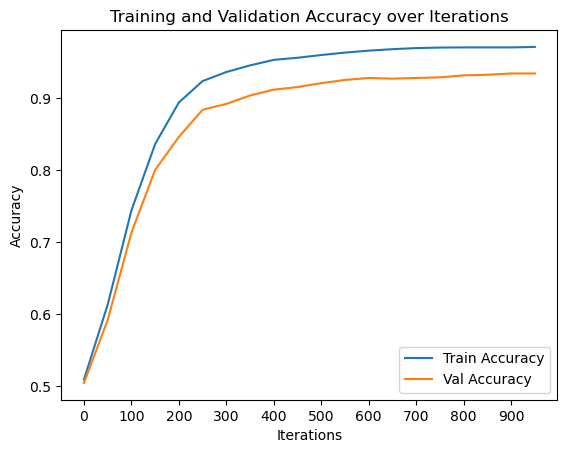

In [68]:
# Initialize and train the model
lr_model = LogisticRegression(learning_rate=0.005, iterations=1000, l2penalty=0.05)
history = lr_model.fit(X_train, y_train, X_test, y_test, verbose=True)

# Plot accuracy over iterations
for key, values in history.items():
    iterations = list(values.keys())
    accuracies = list(values.values())
    plt.plot(iterations, accuracies, label=f'{key.capitalize()} Accuracy')
    
plt.title('Training and Validation Accuracy over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.xticks(list(history['train'].keys())[::2])  # Show only the saved iterations on x-axis
plt.legend()
plt.show()

## Model Evaluation

True Distribution: {'no': 998, 'yes': 115}
Pred Distribution: {'no': 1022, 'yes': 91}
True Positives: 974
True Negatives: 67
False Positives: 48
False Negatives: 24

Recall: 0.9760
AUC-ROC: 0.4174
Specificity: 0.5826
Precision: 0.9530
F1 score: 0.9644
Accuracy: 0.9353


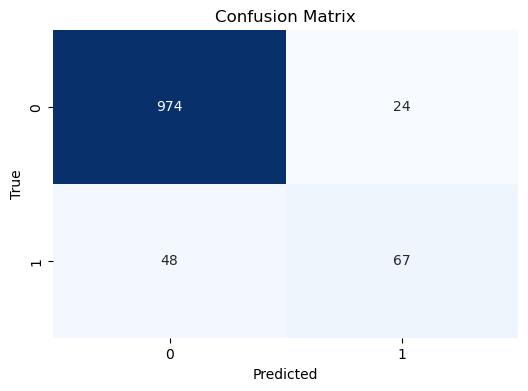

In [69]:
# Build confusion matrix from true and predicted labels
def confusion_matrix(y_true, y_pred, num_classes):
    matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
    for y_true, y_pred in zip(y_true, y_pred):
        matrix[y_true][y_pred] += 1
    return matrix

# Calculate class distribution based on confusion matrix
def distribution(matrix, classes, actual=True):
    distribution = {}; counts = [0]*len(classes)
    for i in range(len(classes)):
        if actual == True: counts[i] = sum(matrix[i])
        else: counts[i] = sum(matrix[j][i] for j in range(len(classes)))
    for i, cls in enumerate(classes):
        distribution[cls] = counts[i]
    return distribution

# Print statistics based on the confusion matrix
def describe_stats(matrix):
    (Tp, Fn), (Fp, Tn) = matrix
    print("True Positives:", Tp)
    print("True Negatives:", Tn)
    print("False Positives:", Fp)
    print("False Negatives:", Fn)

    recall = Tp/(Tp+Fn)
    precision = Tp/(Tp+Fp)
    f1 = 2*(precision*recall)/(precision+recall)
    print(f"\nRecall: {Tp/(Tp+Fn):.4f}")
    print(f"AUC-ROC: {Fp/(Fp+Tn):.4f}")
    print(f"Specificity: {Tn/(Tn+Fp):.4f}")
    print(f"Precision: {Tp/(Tp+Fp):.4f}")
    print(f"F1 score: {f1:.4f}")
    print(f"Accuracy: {(Tp+Tn)/(Tp+Tn+Fp+Fn):.4f}")

y_true = y_test
y_pred = lr_model.predict(X_test)
matrix = confusion_matrix(y_true, y_pred, len(classes))
print("True Distribution:", distribution(matrix, classes))
print("Pred Distribution:", distribution(matrix, classes, False))
describe_stats(matrix)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Cross-Validation

In [14]:
# Split data into k folds for cross-validation
def kfold_split(x, k=5):
    remainder = len(X) % k
    fold_size = len(x) // k
    indices = np.arange(len(x))
    np.random.shuffle(indices)
    folds = [indices[i*fold_size: (i+1)*fold_size] for i in range(k)]

    # Distribute any remaining indices to the first few folds
    if remainder > 0:
        for i in range(remainder):
            folds[i] = np.append(folds[i], indices[-(i+1)])
    return folds 

# Perform k-fold cross-validation
def kfold_cross_validation(X, y, model, k=5):
    accuracies = []
    folds = kfold_split(X, k)
    for i, test_indices in enumerate(folds):
        train_indices = np.hstack([folds[j] for j in range(k) if j != i])
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Normalize input and Train the model
        X_train = normalizeInput(X_train)
        X_test = normalizeInput(X_test)
        model.fit(X_train, y_train)

        # Predict and Evaluate
        y_pred = model.predict(X_test)
        y_predt = model.predict(X_train)
        test_acc = model.evaluate(y_test, y_pred)
        train_acc = model.evaluate(y_train, y_predt)

        accuracies.append(test_acc)
        print(f'Accuracy for fold {i+1}: {train_acc:.5f} - {test_acc:.5f}')
    return accuracies

X = features; y = labels; k = 5
model = LogisticRegression(learning_rate=0.05, iterations=1500, l2penalty=0.1)
accuracies = kfold_cross_validation(X, y, model, k)
print(f'Average accuracy: {np.mean(accuracies)}')
print(f'Standard Deviation: {np.std(accuracies)}')

Accuracy for fold 1: 0.97147 - 0.92633
Accuracy for fold 2: 0.97034 - 0.91914
Accuracy for fold 3: 0.97102 - 0.92363
Accuracy for fold 4: 0.96787 - 0.92093
Accuracy for fold 5: 0.96923 - 0.93255
Average accuracy: 0.924516182202486
Standard Deviation: 0.004699443037104182


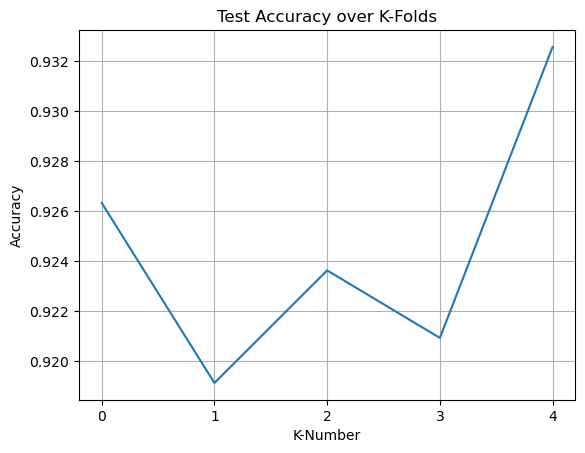

In [24]:
# Plot accuracies over each kfold
folds = list(range(k))
plt.plot(folds, accuracies, label=f'Accuracy')
plt.title('Test Accuracy over K-Folds')
plt.xlabel('K-Number')
plt.ylabel('Accuracy')
plt.xticks(folds)
plt.grid()
plt.show()

## Error Analysis

In [94]:
# Show n missclassified examples with predicted labels
def show_misclassified(y_test, y_pred, seqs, classes):
    indices = np.where(y_test != y_pred)[0]
    for index in indices[:10]:
        sequence, label = seqs[index], y_test[index]
        print(f'Label: {classes[label]},  Sequence: {sequence}')

show_misclassified(y_test, y_pred, seqs, classes)

Label: no,  Sequence: britain's storey storey retained olympic 100m title victory track cycling world championships london
Label: yes,  Sequence: close ftse 100 ended day higher shares airlines ftse 100 higher
Label: yes,  Sequence: tom ince scored goal game give derby county first win season beat ipswich town
Label: yes,  Sequence: dumfries teacher downloaded hundreds indecent images children struck
Label: yes,  Sequence: older people care given quality care older people care watchdog said
Label: no,  Sequence: woman critical condition hospital hit car aberdeenshire
Label: no,  Sequence: motorcyclist arrested suspicion causing death dangerous driving crash lorry lorry
Label: yes,  Sequence: inverness caledonian thistle ended run three straight scottish premiership defeats win hamilton academical
Label: yes,  Sequence: year's london fringe festival taking place london
Label: yes,  Sequence: wales coach warren gatland lot frustration''in world cup says head coach warren gatland


#### Reasons for Misclassification
1. **Inherent Bias in Training Data:** The training data is significantly imbalanced. So, model ends up biased towards the majority class. This leads to a higher rate of false negatives or positives.

2. **Ambiguity in Content:** Many sequences with the label "yes" discuss events that could be perceived as newsworthy (e.g., sports results, political statements). In contrast, some "no" sequences also contain words which lead the model to misclassifying them.

3. **Lack of Contextual Understanding:** Logistic regression struggles with complex relationships in the data. Sequences that reference ongoing societal issues (e.g., healthcare, crime) might be misclassified due to their sensitive nature.

4. **Phrase Complexity:** Phrases with mixed signals or unclear phrases (e.g., "older people care... watchdog said") confuse the model due to limitations of Bag of Words/Inverse Document Frequency based features

#### Suggested Improvements:
1. **Feature Engineering:** Enhance the feature set to include more contextual information, such as word embeddings (e.g., Word2Vec, GloVe, BERT) to capture semantic meaning better.

2. **Data Augmentation:** Increase the size of the training dataset through augmentation techniques (e.g., paraphrasing, synonym replacement) to improve the model's robustness and reduce bias. Synthetic data can be used to remove class imbalance

3. **Advanced Models:** Try more sophisticated models like Random Forests or deep learning (e.g., BERT) for better context capture.

## Conclusion

In this assignment, a logistic regression model was implemented from scratch for hallucination detection using the XSum dataset. The task required classifying summaries as either factual or hallucinated based on the given labels. After preprocessing and hyperparameter tuning, the model was evaluated with accuracy, precision, recall, and F1 score. K-fold cross-validation confirmed the model's robustness. Error analysis highlighted misclassifications due to ambiguity and lack of context. Suggestions for improvement included using advanced models like BERT to better capture text semantics.